<a href="https://colab.research.google.com/github/RajidiSahithi/Session_10/blob/main/Copy_of_S10_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install albumentations==0.4.6
%pip install  torch_lr_finder
%pip install torch


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import transforms

torch.manual_seed(1)


def get_a_train_transform():
    """Get transformer for training data

    Returns:
        Compose: Composed transformations
    """
    return A.Compose([
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616), always_apply = True
        ),
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=(-0.2, 0.2), scale_limit=(-0.2, 0.2), rotate_limit=(-15, 15), p=0.5),
        A.PadIfNeeded(min_height=36, min_width=36, p=1.0),
        A.RandomCrop (32, 32, always_apply=False, p=1.0),
        A.CenterCrop(32, 32, always_apply=False, p=1.0),
        #A.RandomBrightnessContrast(p=0.5, always_apply = False),
        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8,
                        fill_value=(0.4914, 0.4822, 0.4465), always_apply=False, p=0.5),

        ToTensorV2()
        ])



def get_a_test_transform():
    """Get transformer for test data

    Returns:
        Compose: Composed transformations
    """
    return A.Compose([
         A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), always_apply = True),
                                  ToTensorV2()
    ])





In [4]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor


torch.manual_seed(1)


class Cifar10SearchDataset(Dataset):
    """
    Custom Dataset Class

    """

    def __init__(self, dataset, transforms=None):
        """Initialize Dataset

        Args:
            dataset (Dataset): Pytorch Dataset instance
            transforms (Transform.Compose, optional): Tranform function instance. Defaults to None.
        """
        self.transforms = transforms
        self.dataset = dataset

    def __len__(self):
        """Get dataset length

        Returns:
            int: Length of dataset
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """Get an item form dataset

        Args:
            idx (int): id of item in dataset

        Returns:
            (tensor, int): Return tensor of transformer image, label
        """
        # Read Image and Label
        image, label = self.dataset[idx]#,self.targets[idx]

        image = np.array(image)

        # Apply Transforms
        if self.transforms is not None:
            image = (self.transforms(image=image))["image"]


        return (image, label)


def get_loader(train_transform, test_transform, batch_size=128, use_cuda=True):
    """Get instance of tran and test loaders
    self.batch_size = 128
        self.device = device
        self.use_cuda = use_cuda
    Args:
        train_transform (Transform): Instance of transform function for training
        test_transform (Transform): Instance of transform function for validation
        batch_size (int, optional): batch size to be uised in training. Defaults to 64.
        use_cuda (bool, optional): Enable/Disable Cuda Gpu. Defaults to True.

    Returns:
        (DataLoader, DataLoader): Get instance of train and test data loaders
    """
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else dict(shuffle=True, batch_size=64)

    train_loader = DataLoader(
        Cifar10SearchDataset(datasets.CIFAR10('../data', train=True,
                     download=True), transforms=train_transform),
        batch_size=batch_size, shuffle=True, **kwargs)

    test_loader = DataLoader(
        Cifar10SearchDataset(datasets.CIFAR10('../data', train=False,
                     download=True), transforms=test_transform),
        batch_size=batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

In [5]:
batch_size = 512
use_cuda=True
train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)


print(get_a_train_transform())

print(get_a_test_transform())

print(train_loader)
print('length of train_loader',len(train_loader))
print(test_loader)
print('length of test_loader',len(test_loader))


Files already downloaded and verified
Files already downloaded and verified
Compose([
  Normalize(always_apply=True, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616), max_pixel_value=255.0),
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.2, 0.2), scale_limit=(-0.19999999999999996, 0.19999999999999996), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None),
  PadIfNeeded(always_apply=False, p=1.0, min_height=36, min_width=36, border_mode=4, value=None, mask_value=None),
  RandomCrop(always_apply=False, p=1.0, height=32, width=32),
  CenterCrop(always_apply=False, p=1.0, height=32, width=32),
  CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8),
  ToTensorV2(always_apply=True, p=1.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Compose([
  Normalize(always_apply=True, p=1.0, mean=(0.4

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader



def print_samples(loader, count=16):
    """Print samples input images

    Args:
        loader (DataLoader): dataloader for training data
        count (int, optional): Number of samples to print. Defaults to 16.
    """
    # Print Random Samples
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    if not count % 8 == 0:
        return
    fig = plt.figure(figsize=(15, 5))
    for imgs, labels in loader:
        for i in range(count):
            ax = fig.add_subplot(int(count/8), 8, i + 1, xticks=[], yticks=[])
            ax.set_title(f'{classes[labels[i]]}')
            plt.imshow(imgs[i].numpy().transpose(1, 2, 0))
        break


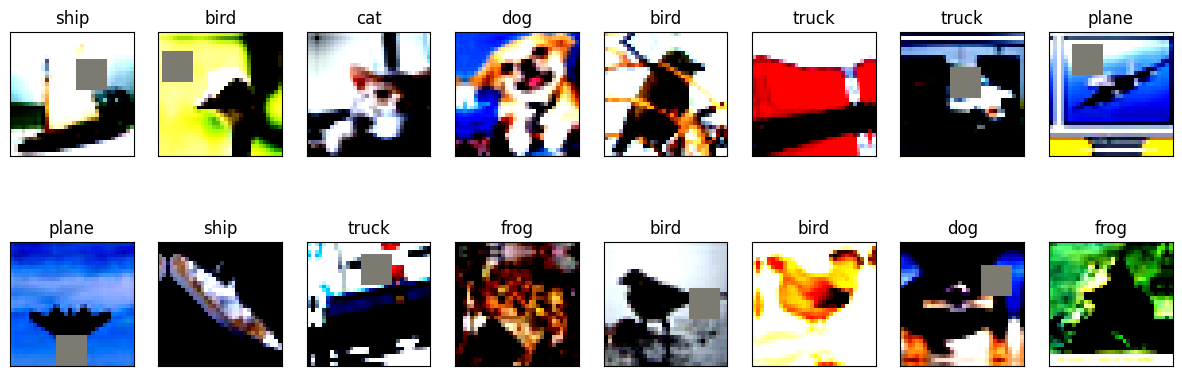

In [7]:
print_samples(train_loader)

In [8]:
import torch.nn.functional as F
import torch
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #drop=0.01
        # Preparation Layer
        self.conv1 = nn.Sequential (
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            )  # Number of Parameters = 3*3*3*64=1728
        # Layer 1
        self.conv11 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,bias=False),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            )  # Number of Parameters = 3*3*64*128 = 73728
        self.conv12 = nn.Sequential(
            nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1,bias=False),# Number of Parameters = 3*3*64*128 = 73728
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1,bias=False),# Number of Parameters = 3*3*64*128 = 73728
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            )

        # Layer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1,bias=False),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            )

        # Layer 3
        self.conv31 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1,bias=False),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
            )
        self.conv32 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
            )

        self.maxpool = nn.MaxPool2d(kernel_size=4,stride=2)

        # Fully connected
        self.fc = nn.Linear(512, 10, bias=True)


    def forward(self, x):
        x = self.conv1(x)

        x = self.conv11(x)
        R1=x
        x = self.conv12(x)
        x=x+R1

        x = self.conv2(x)

        x = self.conv31(x)
        R2=x
        x = self.conv32(x)
        x=x+R2

        x = self.maxpool(x)
        #x = x.randn(512, 1)

# squeeze the tensor to size 512x
        x = x.squeeze(dim=[2, 3])

        #x = x.view(512, 10)

        x = self.fc(x)

        x = x.view(-1, 10)
        return x
        #y = F.log_softmax(x, dim=-1)
        #return  y

def model_summary(model,input_size):
    model = Net().to(device)
    summary(model, input_size=(3, 32, 32))
    return model,input_size

In [9]:

import torch
from tqdm import tqdm
import torch.nn.functional as F



def train_model(model, device, train_loader, optimizer, epoch):
    train_losses = []
    #test_losses = []
    train_acc = []
    #test_acc = []
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    #criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(pbar):
    # get samples
        data, target = data.to(device), target.to(device)

    # Init
        #optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
        y_pred = model(data)

    # Calculate loss

        loss = criterion(y_pred, target)
        #loss = F.normalize(loss)
        train_losses.append(loss)
        optimizer.zero_grad()
    # Backpropagation
        loss.backward()
        optimizer.step()

    # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test_model(model, device, test_loader):
    #train_losses = []
    test_losses = []
    #train_acc = []
    test_acc = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += criterion(output, target).item()
            #test_loss = F.normalize(test_loss)
            pred =output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set:  Accuracy: {}/{} ({:.2f}%)\n'.format(
         correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
%pip install torchsummary
from torchsummary import summary


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [11]:
model

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv11): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (conv12): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (co

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.10E-03


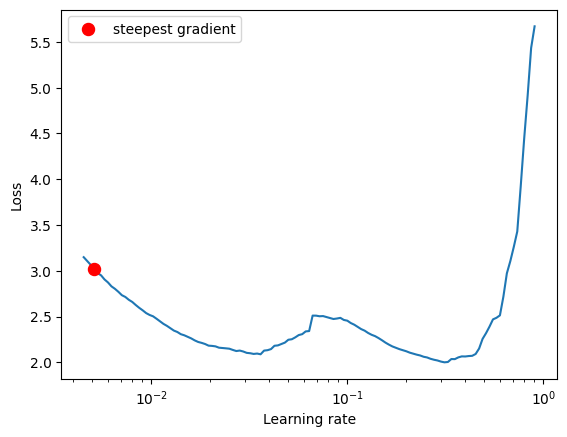

Min Loss = 1.9998548591386085, Max LR = 0.31278995474886595


In [60]:

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch_lr_finder import LRFinder

model =  Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph

min_loss = min(lr_finder.history["loss"])
max_lr = lr_finder.history["lr"][np.argmin(lr_finder.history["loss"], axis=0)]

print("Min Loss = {}, Max LR = {}".format(min_loss, max_lr))

    # Reset the model and optimizer to initial state
lr_finder.reset()






In [61]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24
learning_rate=[]
scheduler = OneCycleLR(
        optimizer,
        max_lr=5.10E-03,
        steps_per_epoch=1,
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

EPOCHS = 24
for epoch in range(EPOCHS):
    scheduler.step()
    print("EPOCH:", epoch)
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    train_model(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test_model(model, device, test_loader)

    learning_rate.append(param_group['lr'])

EPOCH: 0
lr=  0.0013132500000000002


Loss=1.248680591583252 Batch_id=97 Accuracy=43.14: 100%|██████████| 98/98 [00:35<00:00,  2.76it/s]



Test set:  Accuracy: 5043/10000 (50.43%)

EPOCH: 1
lr=  0.0025755


Loss=0.8985209465026855 Batch_id=97 Accuracy=61.86: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set:  Accuracy: 6698/10000 (66.98%)

EPOCH: 2
lr=  0.00383775


Loss=0.7585955262184143 Batch_id=97 Accuracy=69.79: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set:  Accuracy: 7362/10000 (73.62%)

EPOCH: 3
lr=  0.0051


Loss=0.7854483723640442 Batch_id=97 Accuracy=73.97: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set:  Accuracy: 7734/10000 (77.34%)

EPOCH: 4
lr=  0.0048316057894736844


Loss=0.6377790570259094 Batch_id=97 Accuracy=77.96: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]



Test set:  Accuracy: 7824/10000 (78.24%)

EPOCH: 5
lr=  0.0045632115789473685


Loss=0.5421627759933472 Batch_id=97 Accuracy=80.65: 100%|██████████| 98/98 [00:34<00:00,  2.82it/s]



Test set:  Accuracy: 8225/10000 (82.25%)

EPOCH: 6
lr=  0.004294817368421053


Loss=0.41041234135627747 Batch_id=97 Accuracy=82.67: 100%|██████████| 98/98 [00:34<00:00,  2.80it/s]



Test set:  Accuracy: 8057/10000 (80.57%)

EPOCH: 7
lr=  0.004026423157894737


Loss=0.44856294989585876 Batch_id=97 Accuracy=83.67: 100%|██████████| 98/98 [00:35<00:00,  2.77it/s]



Test set:  Accuracy: 8306/10000 (83.06%)

EPOCH: 8
lr=  0.003758028947368421


Loss=0.47323381900787354 Batch_id=97 Accuracy=85.00: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]



Test set:  Accuracy: 8430/10000 (84.30%)

EPOCH: 9
lr=  0.0034896347368421057


Loss=0.43903249502182007 Batch_id=97 Accuracy=85.90: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]



Test set:  Accuracy: 8326/10000 (83.26%)

EPOCH: 10
lr=  0.0032212405263157898


Loss=0.43171581625938416 Batch_id=97 Accuracy=86.48: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set:  Accuracy: 8166/10000 (81.66%)

EPOCH: 11
lr=  0.002952846315789474


Loss=0.43805062770843506 Batch_id=97 Accuracy=87.35: 100%|██████████| 98/98 [00:34<00:00,  2.82it/s]



Test set:  Accuracy: 8421/10000 (84.21%)

EPOCH: 12
lr=  0.002684452105263158


Loss=0.3574792444705963 Batch_id=97 Accuracy=88.21: 100%|██████████| 98/98 [00:34<00:00,  2.82it/s]



Test set:  Accuracy: 8748/10000 (87.48%)

EPOCH: 13
lr=  0.002416057894736842


Loss=0.31400829553604126 Batch_id=97 Accuracy=89.31: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set:  Accuracy: 8757/10000 (87.57%)

EPOCH: 14
lr=  0.002147663684210526


Loss=0.27936333417892456 Batch_id=97 Accuracy=89.85: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set:  Accuracy: 8770/10000 (87.70%)

EPOCH: 15
lr=  0.0018792694736842106


Loss=0.3380833566188812 Batch_id=97 Accuracy=90.53: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]



Test set:  Accuracy: 8730/10000 (87.30%)

EPOCH: 16
lr=  0.0016108752631578947


Loss=0.2287600189447403 Batch_id=97 Accuracy=91.10: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set:  Accuracy: 8902/10000 (89.02%)

EPOCH: 17
lr=  0.0013424810526315788


Loss=0.23809483647346497 Batch_id=97 Accuracy=91.80: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set:  Accuracy: 9027/10000 (90.27%)

EPOCH: 18
lr=  0.0010740868421052633


Loss=0.21895338594913483 Batch_id=97 Accuracy=92.96: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set:  Accuracy: 9118/10000 (91.18%)

EPOCH: 19
lr=  0.0008056926315789473


Loss=0.16786959767341614 Batch_id=97 Accuracy=93.69: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]



Test set:  Accuracy: 9128/10000 (91.28%)

EPOCH: 20
lr=  0.0005372984210526314


Loss=0.17662493884563446 Batch_id=97 Accuracy=94.66: 100%|██████████| 98/98 [00:34<00:00,  2.88it/s]



Test set:  Accuracy: 9167/10000 (91.67%)

EPOCH: 21
lr=  0.0002689042105263155


Loss=0.13289634883403778 Batch_id=97 Accuracy=95.33: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]



Test set:  Accuracy: 9255/10000 (92.55%)

EPOCH: 22
lr=  5.099999999995733e-07


Loss=0.13039898872375488 Batch_id=97 Accuracy=95.63: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]



Test set:  Accuracy: 9254/10000 (92.54%)

EPOCH: 23
lr=  -0.00026788421052631635


Loss=296.99114990234375 Batch_id=97 Accuracy=31.46: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]



Test set:  Accuracy: 819/10000 (8.19%)

